# Identification of human sequences

We'll try to replicate the [Classifying human DNA sequence and random ATCG sequences, using keras CNN](https://github.com/onceupon/deep_learning_DNA) problem, but using PyTorch instead.

In [8]:
import torch
from torch import nn
import pandas as pd
import os

In [9]:
dataset = pd.read_csv("datasets/testing/human-exercise.csv")
print(dataset.shape)
dataset

(20000, 2)


,sequence,label
0,CTACTCGGGAGGCTGAGGCAGGAGAATCACTTGAACCAGGGAGTCA...,1
1,CACCTTATCCAGAGAAGCTTCTTCTTTTAGAAAATCAAGCAAAACA...,1
2,AAAGGGGCTGATAGAAAAATAAAGAGATTTGGCCAGGTACGGTGGC...,1
3,AAGTGGATATTCAGACCTCCTTGAGGCCTTCGTTGGAAACGGGATT...,1
4,ATACCATGACAAAGATATTATTAGCCAATTTTTAGAGAGAAGGAAA...,1
...,...,...
19995,AAGACGAGTGGTTACCCCCTGTGAGACTGCCGCGCGTGGTGGTCGG...,0
19996,ACGAGGCCATCTAGAGCGCAACGAAACTGCAAGAAAATACGTCCGA...,0
19997,CATCTTTACCCAATTTGTGTGTGGAAAGGTGTCAGCGATGCTTTGG...,0
19998,ATAAGTAACTCCAGTCGAGCGGAAGGTATAGTGGCACGGGGTTTAG...,0


As we can see, this dataset contains the sequence and the corresponding positive/negative class labels, with positive class labels corresponding to the human DNA. The amount of positive and negative examples is evenly distributed across the two classes.

1    10000
0    10000
Name: label, dtype: int64


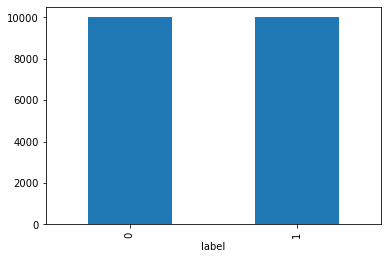

In [10]:
# plot the distribution of each class
dataset.groupby('label').size().plot(kind='bar')

print(dataset['label'].value_counts())

We need now to split the dataset into training, test and validation sets.

In [11]:
fps_x = dataset['sequence'].values
fps_y = dataset['label'].values

Building the model equivalent to the one in the paper.

In [12]:
%load_ext autoreload
%autoreload 2
from src.hyperparameter_tuning import hyperparameter_tuning
from ray import tune

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
torch.manual_seed(2022)
os.environ["CUDA_VISIBLE_DEVICES"] = '4,5'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class_weights = torch.tensor([1.0, 1.0]).to(device)

fixed_vals = {
    'epochs': 50,
    'optimizer_label': 'adam',
    'loss_function': nn.CrossEntropyLoss(weight=class_weights),
    'patience': 2, 
    'output_size': 2,     
    'model_label': 'net',
    'data_dir': 'testing',
    'mode': 'one_hot'
}

config = {
    "hidden_size": tune.choice([32, 64, 128, 256]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([8, 16, 32]),
    "dropout": tune.uniform(0.3, 0.5)
}

In [14]:
hyperparameter_tuning(device, fixed_vals, config)

2022-06-19 01:19:05,439	WARNING experiment.py:295 -- No name detected on trainable. Using DEFAULT.
2022-06-19 01:19:05,440	INFO registry.py:66 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Memory usage on this node: 47.1/754.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/80 CPUs, 2.0/2 GPUs, 0.0/522.29 GiB heap, 0.0/186.26 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jabreu/ray_results/DEFAULT_2022-06-19_01-19-05
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+---------------------+----------+-------+--------------+-----------+---------------+-------------+
| Trial name          | status   | loc   |   batch_size |   dropout |   hidden_size |          lr |
|---------------------+----------+-------+--------------+-----------+---------------+-------------|
| DEFAULT_6dcb9_00000 | RUNNING  |       |           32 |  0.475102 |            64 | 0.000103967 |
| DEFAULT_6dcb9_00001 | PENDING  |       |            8 |  0.323398 |           256 | 0.0118096   |
| DEFAULT_6dcb9_00002 | PENDING  |       |         

2022-06-19 01:25:31,759	INFO tune.py:561 -- Total run time: 386.32 seconds (386.20 seconds for the tuning loop).


Result for DEFAULT_6dcb9_00014:
  accuracy: 0.97075
  date: 2022-06-19_01-25-31
  done: true
  experiment_id: 183b36cfcaff49e2aa8f767d88078013
  hostname: turing
  iterations_since_restore: 2
  loss: 0.3909472825527191
  mcc: 0.9419674495864179
  node_ip: 192.168.85.234
  pid: 1372370
  should_checkpoint: true
  time_since_restore: 7.621133804321289
  time_this_iter_s: 1.6953282356262207
  time_total_s: 7.621133804321289
  timestamp: 1655598331
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 6dcb9_00014
  
== Status ==
Memory usage on this node: 46.8/754.3 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 32.000: None | Iter 16.000: -0.32569046887755393 | Iter 8.000: -0.32798829185962675 | Iter 4.000: -0.3325571270883083 | Iter 2.000: -0.3591637725830078 | Iter 1.000: -0.8132615065574647
Resources requested: 0/80 CPUs, 0/2 GPUs, 0.0/522.29 GiB heap, 0.0/186.26 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jabreu/ray_results/DEFAULT_2022-06-19_01-19